In [ ]:
!pip install pandas matplotlib seaborn scipy numpy

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import os   
import math

In [17]:

sns.set(style="whitegrid", context="talk")

csv_path = "/home/aureliaaa/Downloads/PAAD/PAAD/date/dataset_lunar_energie.csv"

# load, parse dates, coerce numerics
df = pd.read_csv(csv_path, parse_dates=["date"], dayfirst=True)
df = df.sort_values("date").reset_index(drop=True)
# keep a datetime index for time-series plots
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.set_index("date")

# coerce all other columns to numeric where possible (NA -> NaN)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

In [23]:
# Define numeric columns (exclude date, year, month, and zero-variance columns)
numeric_cols = [c for c in df.select_dtypes(include="number").columns 
                if c not in ("year", "month", "variatia_stocurilor", "rotor_area_m2")]
print(f"Numeric columns: {numeric_cols}")

Numeric columns: ['ALLSKY_SFC_SW_DWN', 'CLOUD_AMT', 'PRECTOTCORR_SUM', 'PS', 'RH2M', 'T2M', 'WS50M', 'producere', 'import', 'procurat_din_alte_surse', 'export', 'consum_final_brut', 'consum_sector_rezidential', 'pv_energy_kwh_day', 'wind_energy_kwh_day']


In [24]:
# DELETE cell #VSC-f99b1ac7 entirely (the first full heatmap)
# KEEP cell #VSC-4a3115bd (triangle heatmap)

# Then add this after defining numeric_cols - recalculate corr_matrix once
corr_matrix = df[numeric_cols].corr()
print(f"Correlation matrix shape: {corr_matrix.shape}")
print(f"Columns in matrix: {list(corr_matrix.columns)}")

Correlation matrix shape: (15, 15)
Columns in matrix: ['ALLSKY_SFC_SW_DWN', 'CLOUD_AMT', 'PRECTOTCORR_SUM', 'PS', 'RH2M', 'T2M', 'WS50M', 'producere', 'import', 'procurat_din_alte_surse', 'export', 'consum_final_brut', 'consum_sector_rezidential', 'pv_energy_kwh_day', 'wind_energy_kwh_day']


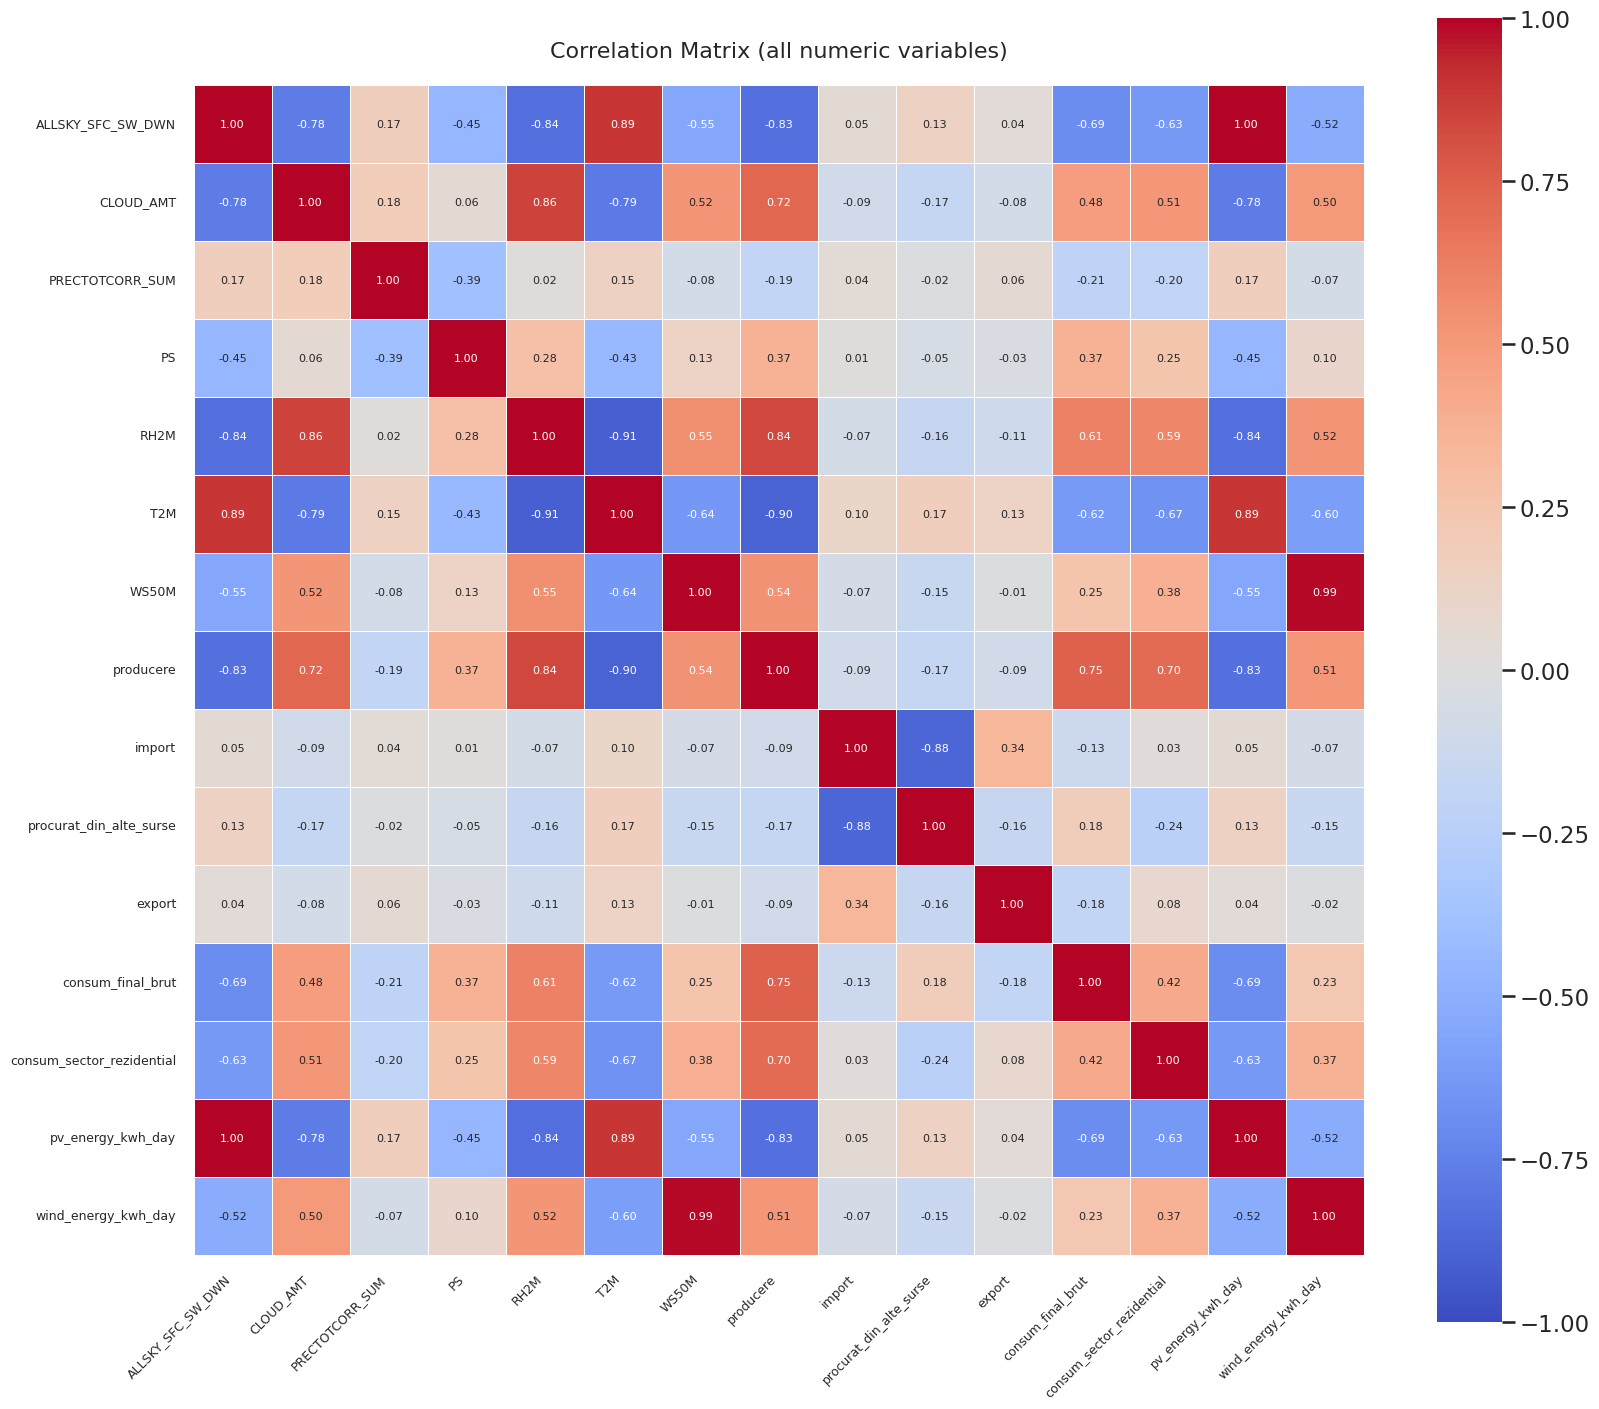

In [25]:
# 1.1) Correlation heatmap
fig, ax = plt.subplots(figsize=(17, 17))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax, 
            vmin=-1, vmax=1, annot_kws={"size": 8})
ax.set_title("Correlation Matrix (all numeric variables)", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()
plt.close(fig)




Pairplot using top 8 correlated variables: ['pv_energy_kwh_day', 'RH2M', 'T2M', 'WS50M', 'wind_energy_kwh_day', 'import', 'CLOUD_AMT', 'ALLSKY_SFC_SW_DWN']



/home/aureliaaa/Downloads/PAAD/.venv/lib64/python3.13/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/aureliaaa/Downloads/PAAD/.venv/lib64/python3.13/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/aureliaaa/Downloads/PAAD/.venv/lib64/python3.13/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/aureliaaa/Downloads/PAAD/.venv/lib64/python3.13/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill

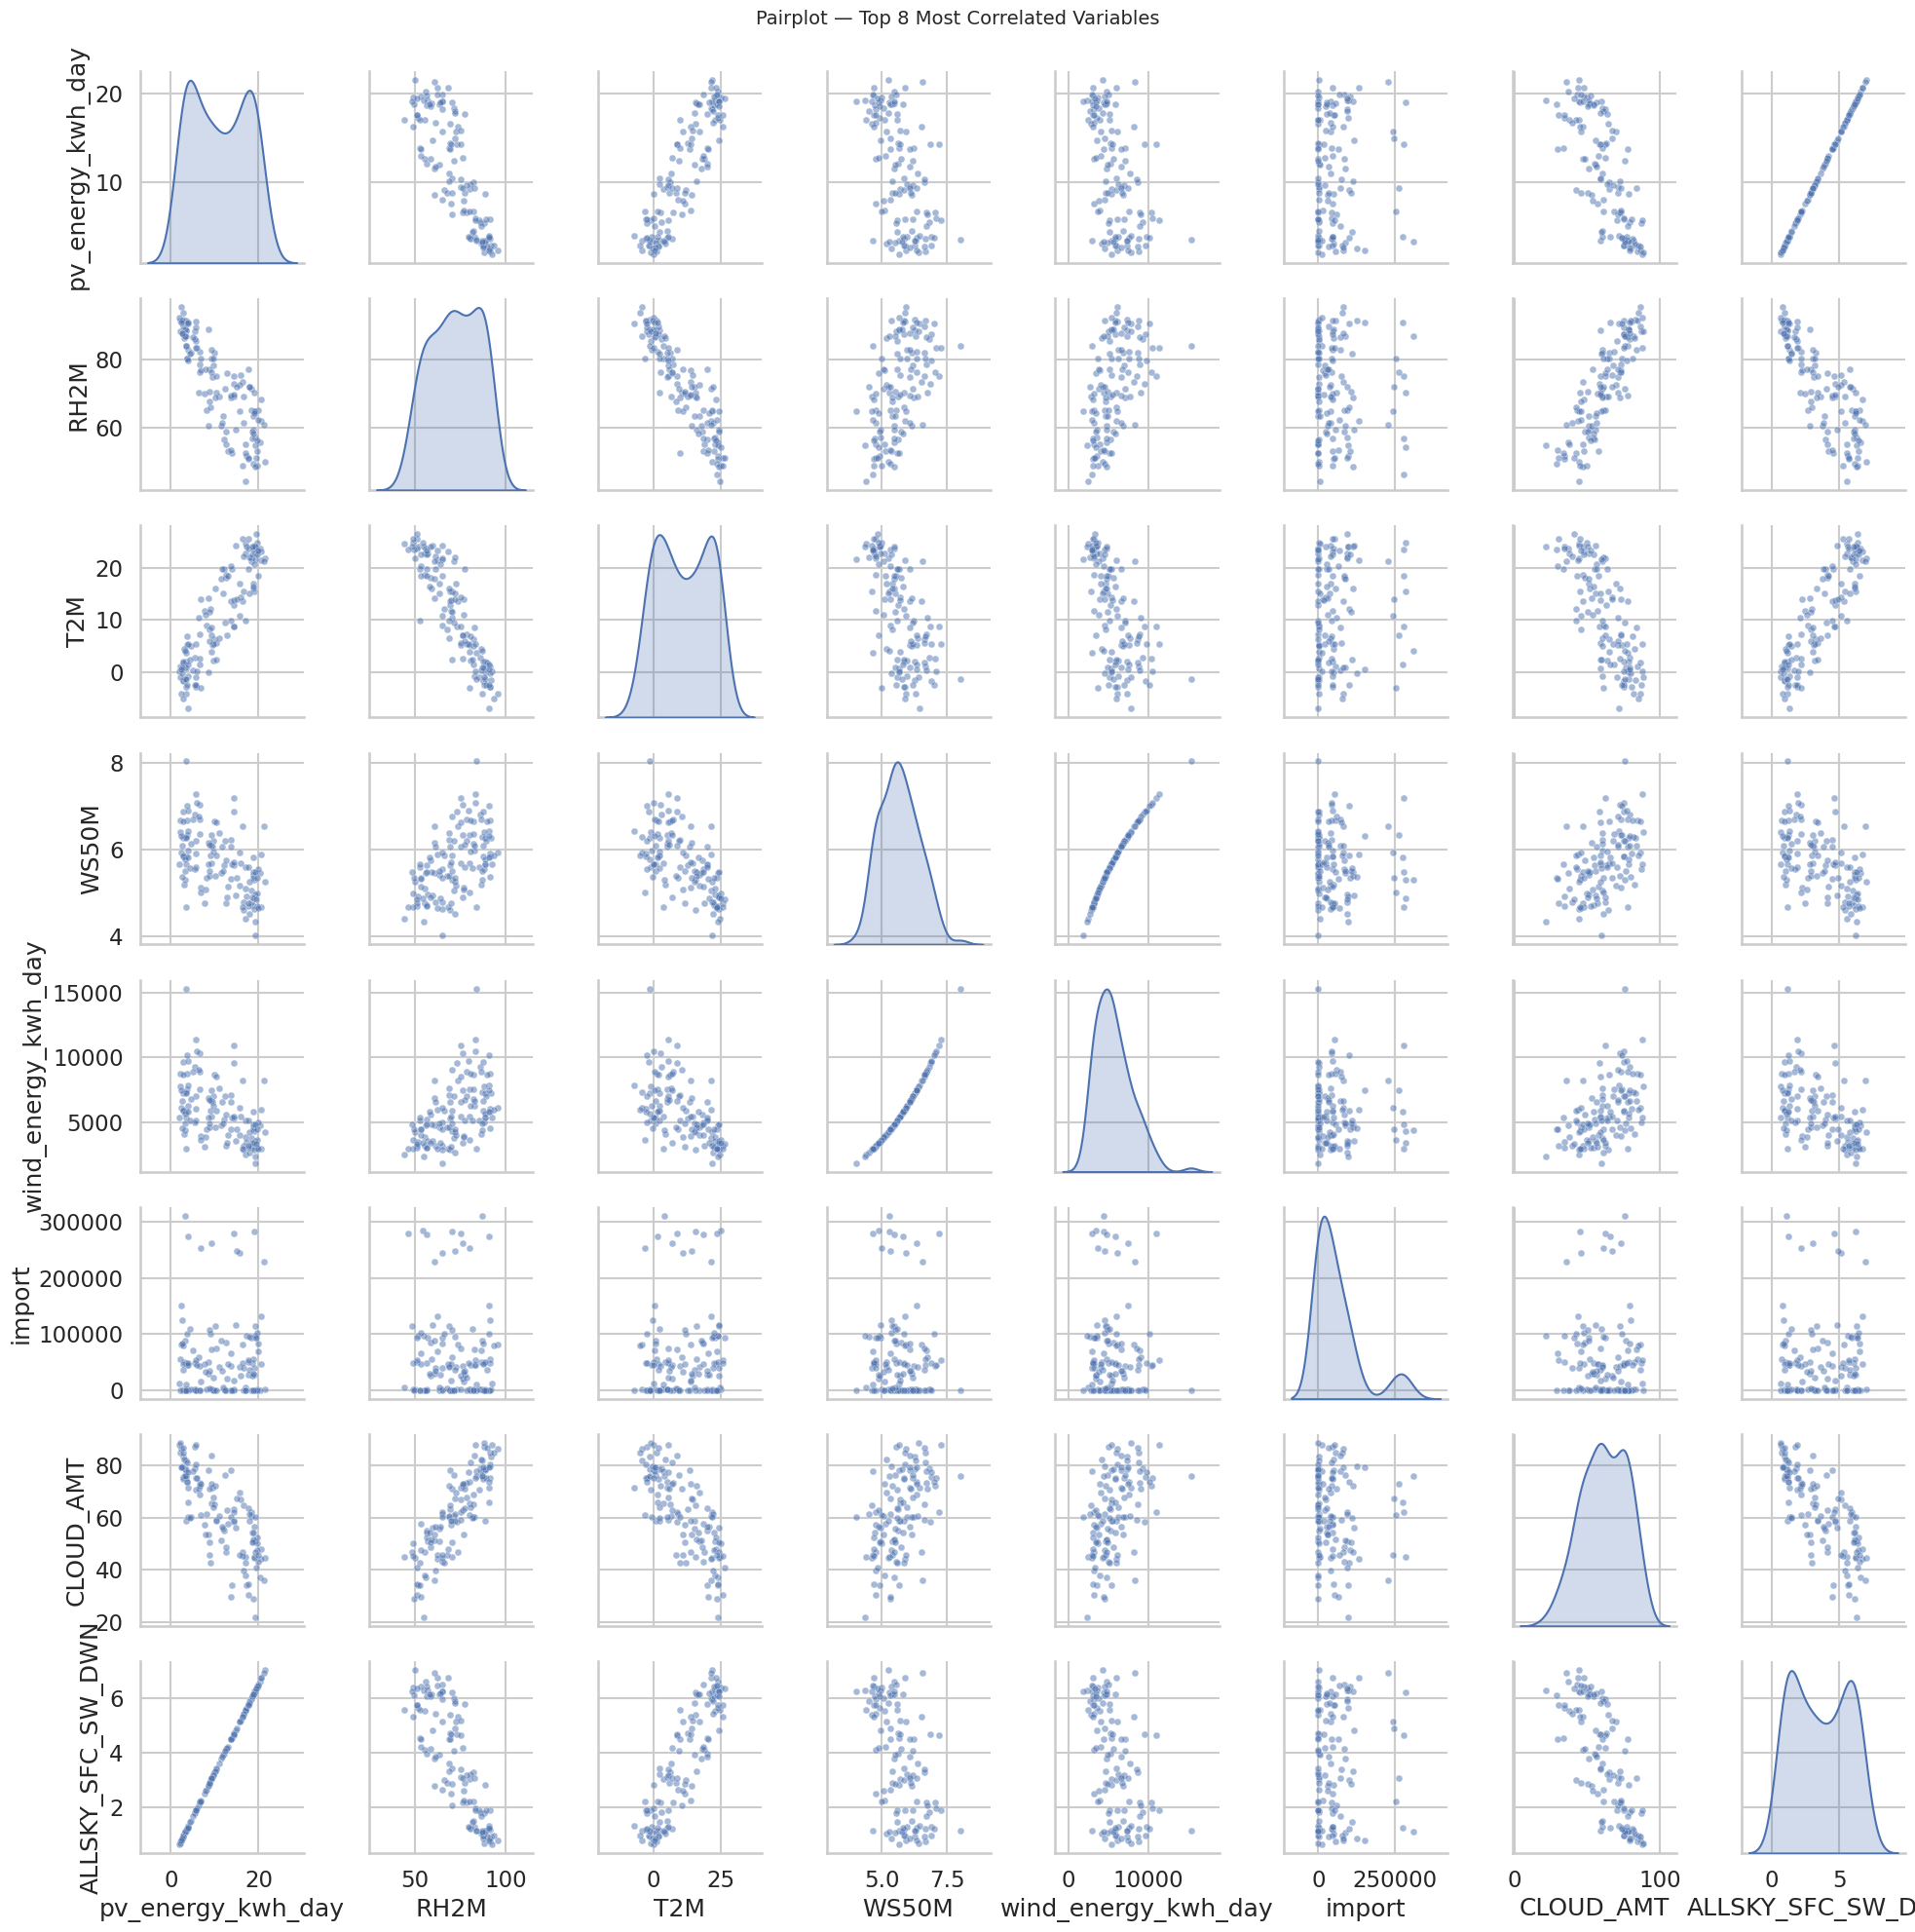

In [26]:
# 2) Scatter plot matrix (pairplot) - use top correlated variables
# Get top 6 most correlated pairs and extract unique variables
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                          abs(corr_matrix.iloc[i, j])))
corr_pairs.sort(key=lambda x: x[2], reverse=True)

# Extract top variables from strongest correlations
top_vars = set()
for col1, col2, _ in corr_pairs[:8]:
    top_vars.add(col1)
    top_vars.add(col2)
top_vars = list(top_vars)[:8]  # Limit to 8 variables max

if len(top_vars) >= 3:
    print(f"Pairplot using top {len(top_vars)} correlated variables: {top_vars}\n")
    pairplot = sns.pairplot(df[top_vars], diag_kind="kde", plot_kws={"alpha": 0.5, "s": 25}, 
                            diag_kws={"shade": True, "linewidth": 1.5})
    pairplot.fig.suptitle(f"Pairplot — Top {len(top_vars)} Most Correlated Variables", fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()
    plt.close(pairplot.fig)
else:
    print(f"Not enough variables for pairplot.")

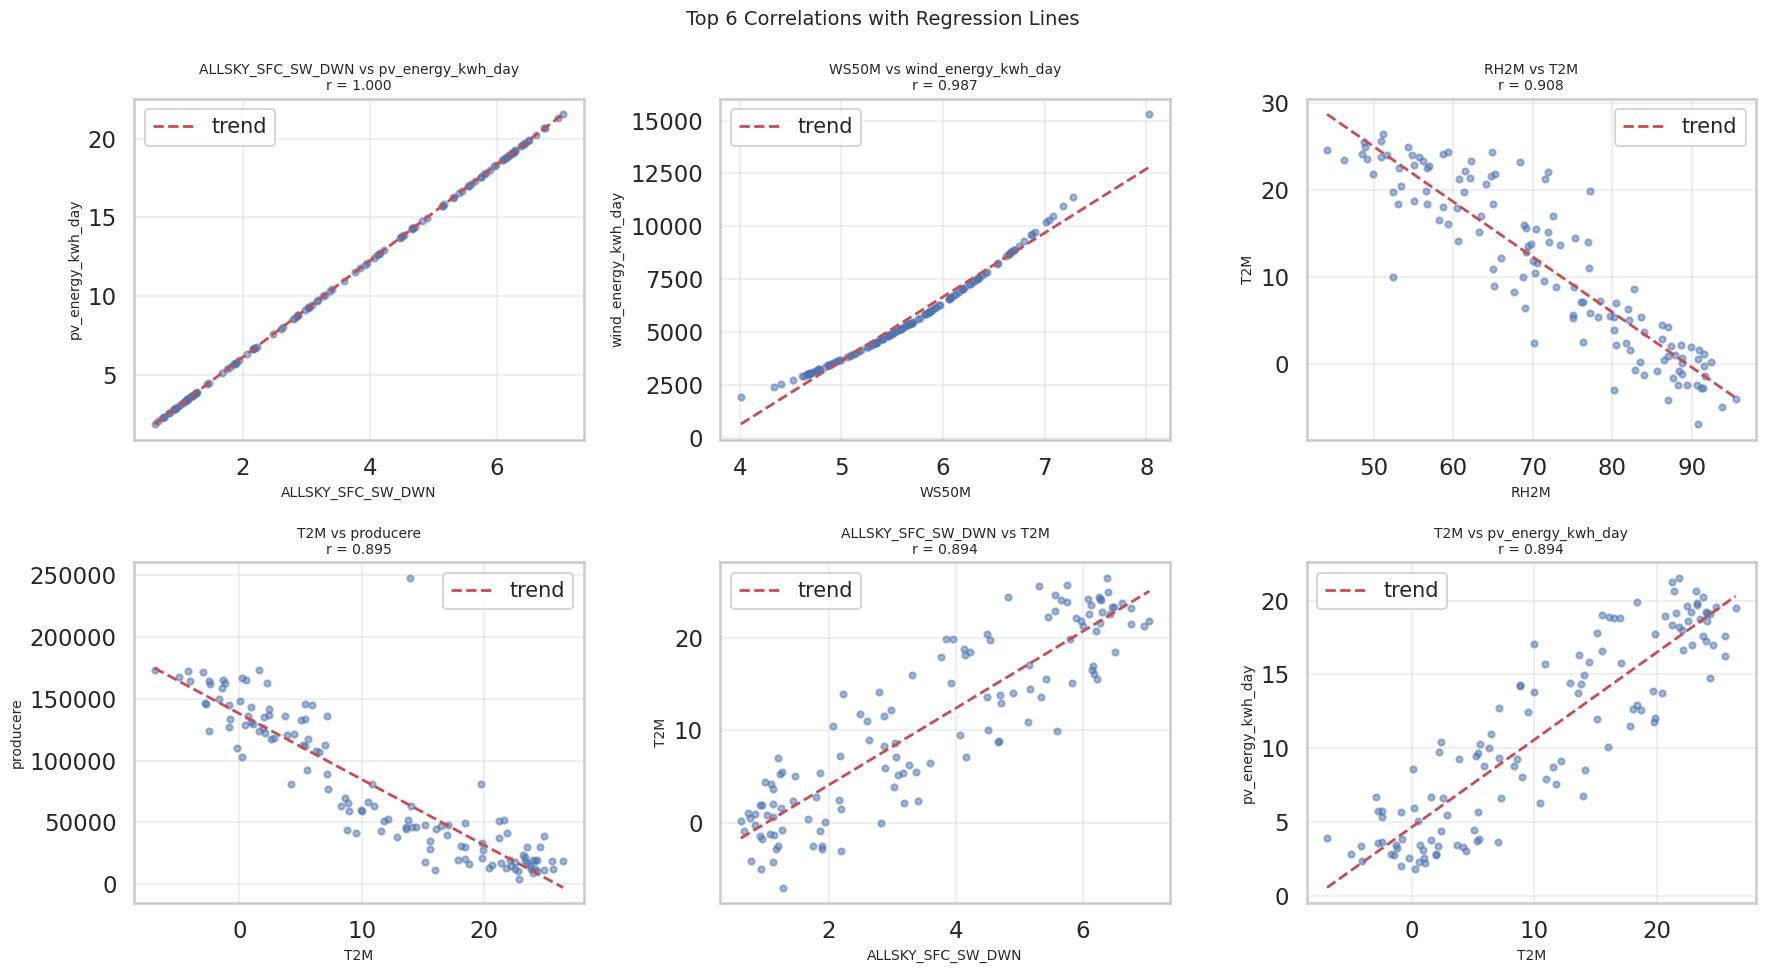

In [27]:
# 3) Scatter plots with regression lines for top correlations
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                          abs(corr_matrix.iloc[i, j])))
corr_pairs.sort(key=lambda x: x[2], reverse=True)
top_corr = corr_pairs[:6]  # Top 6 correlations

if top_corr:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    for idx, (col1, col2, corr_val) in enumerate(top_corr):
        ax = axes[idx]
        # Scatter plot
        valid_data = df[[col1, col2]].dropna()
        if len(valid_data) > 1:
            ax.scatter(valid_data[col1], valid_data[col2], alpha=0.5, s=20)
            # Add regression line (fixed - use valid data only)
            z = np.polyfit(valid_data[col1], valid_data[col2], 1)
            p = np.poly1d(z)
            x_line = np.linspace(valid_data[col1].min(), valid_data[col1].max(), 100)
            ax.plot(x_line, p(x_line), "r--", linewidth=2, label="trend")
        ax.set_xlabel(col1, fontsize=10)
        ax.set_ylabel(col2, fontsize=10)
        ax.set_title(f"{col1} vs {col2}\nr = {corr_val:.3f}", fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize="small")
    
    for j in range(len(top_corr), len(axes)):
        axes[j].axis("off")
    fig.suptitle("Top 6 Correlations with Regression Lines", fontsize=14)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [28]:
# 5) Correlation summary table - all pairs sorted by strength
corr_summary = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        col1 = corr_matrix.columns[i]
        col2 = corr_matrix.columns[j]
        corr_val = corr_matrix.iloc[i, j]
        corr_summary.append({
            "Variable 1": col1,
            "Variable 2": col2,
            "Correlation": corr_val,
            "Abs Correlation": abs(corr_val),
            "Strength": "Very Strong" if abs(corr_val) > 0.8 else "Strong" if abs(corr_val) > 0.6 else "Moderate" if abs(corr_val) > 0.4 else "Weak" if abs(corr_val) > 0.2 else "Very Weak"
        })

corr_df = pd.DataFrame(corr_summary).sort_values("Abs Correlation", ascending=False)
display(corr_df.reset_index(drop=True))

,Variable 1,Variable 2,Correlation,Abs Correlation,Strength
0,ALLSKY_SFC_SW_DWN,pv_energy_kwh_day,1.000000,1.000000,Very Strong
1,WS50M,wind_energy_kwh_day,0.986537,0.986537,Very Strong
2,RH2M,T2M,-0.908097,0.908097,Very Strong
3,T2M,producere,-0.895022,0.895022,Very Strong
4,ALLSKY_SFC_SW_DWN,T2M,0.893932,0.893932,Very Strong
...,...,...,...,...,...
100,PRECTOTCORR_SUM,RH2M,0.023250,0.023250,Very Weak
101,PRECTOTCORR_SUM,procurat_din_alte_surse,-0.023154,0.023154,Very Weak
102,export,wind_energy_kwh_day,-0.016833,0.016833,Very Weak
103,PS,import,0.014585,0.014585,Very Weak


În analiza univariată a datelor energetice lunare, am urmat pașii de mai jos:

**1. Prelucrarea datelor**
- Am încărcat setul de date `dataset_lunar_energie.csv`, am convertit coloana de dată și am setat-o ca index.
- Am transformat toate coloanele relevante la tip numeric, gestionând valorile lipsă.

**2. Identificarea variabilelor numerice**
- Am selectat variabilele numerice relevante, excluzând coloane neinformative (ex: `year`, `month`, etc.).

**3. Statistici descriptive și meta-informații**
- Am calculat statistici descriptive pentru fiecare variabilă numerică: medie, deviație standard, minim, maxim, quartile, skewness, kurtosis, coeficient de variație.
- Am analizat tipul de date, numărul de valori lipsă și numărul de valori unice.

**4. Detectarea outlierilor**
- Am folosit două metode: regula IQR și scorul Z pentru a identifica valorile extreme din fiecare variabilă numerică.

**5. Vizualizări univariate**
Pentru fiecare variabilă numerică am generat:
- Histograme cu KDE și testul de normalitate Shapiro-Wilk, plus valori de skewness și kurtosis.
- Violin plot pentru distribuție.
- Q-Q plot pentru verificarea normalității.
- ECDF plot pentru distribuția cumulativă.
- Boxplot pentru identificarea outlierilor.
- Grafic de trend cu media mobilă pe 12 perioade pentru a observa evoluția temporală.

**6. Vizualizări agregate**
- Am organizat graficele pe tipuri (histograme, violin, Q-Q, ECDF, boxplot, trend) pentru toate variabilele simultan, facilitând comparația între ele.
- Am realizat analiza autocorelației (ACF) pentru a identifica tipare temporale.

**Rezultate și concluzii**
- Am obținut o imagine detaliată asupra distribuției fiecărei variabile, gradului de normalitate, prezenței outlierilor și evoluției în timp.
- Majoritatea variabilelor prezintă abateri de la normalitate (skewness/kurtosis semnificative, p < 0.05 la Shapiro-Wilk).
- Outlierii au fost identificați și cuantificați.
- Analiza autocorelației a evidențiat posibile tipare sezoniere sau dependențe temporale.
- Metodele folosite au fost: statistici descriptive, testul Shapiro-Wilk, regula IQR, scorul Z, vizualizări statistice (histogramă, KDE, violin, Q-Q, ECDF, boxplot, trend), autocorelație (ACF).

**Modelul analitic**
- Analiza a fost una exploratorie, bazată pe metode statistice descriptive și vizualizări, fără aplicarea unor modele predictive sau de regresie.

**Concluzie**
- Datele prezintă variabilitate semnificativă, cu distribuții adesea asimetrice și prezența outlierilor.
- Evoluția temporală și autocorelația indică existența unor tipare sezoniere.
- Analiza univariată oferă o bază solidă pentru investigații ulterioare (bivariată/multivariată) și pentru selecția variabilelor relevante în modele predictive.